In [12]:
import pyreadstat
import pandas as pd
import numpy as np
import networkx as nx
import warnings
import itertools
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [13]:
df, meta = pyreadstat.read_sav("..\\data\\raw\\OD 2017\\Banco de dados\\OD_2017.sav")
df.drop_duplicates(subset=['zona', 'zona_esc', 'zonatra1', 'id_pess'], inplace=True)

In [14]:
df = df[df['muni_dom'] == 36]
max_zona = int(df.zona.max())

In [15]:
trab_esc = df[['zona', 'zona_esc', 'zonatra1', 'id_pess', 'id_dom', 'idade', 'criteriobr', 'renda_fa']].copy()
trab_esc.rename(columns={'zona':'home',
                        'zona_esc':'school',
                        'zonatra1':'work',
                        'id_pess': 'id', 'id_dom': 'home_id'}, inplace=True)

trab_esc = trab_esc[~(trab_esc['work'] > max_zona) & 
        ~(trab_esc['school'] > max_zona) & ~(trab_esc['home'] > max_zona)].reset_index(drop=True)

In [16]:
# Beneficiarios do Sistema de Saude Privado

quantile = 1 - 5730524/12038175
print('Tem plano de saude aqueles com renda familiar superior a:')
print(np.quantile(trab_esc['renda_fa'], quantile))
print('Será???')

Tem plano de saude aqueles com renda familiar superior a:
4000.0
Será???


In [17]:
trab_esc.groupby(by='criteriobr')['renda_fa'].median()

criteriobr
1.0    11742.852070
2.0     6483.397776
3.0     4209.082629
4.0     2850.000000
5.0     2037.000000
6.0     1592.403836
Name: renda_fa, dtype: float64

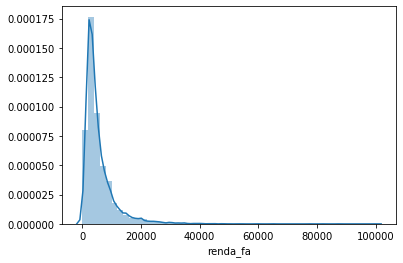

In [18]:
sns.distplot(trab_esc['renda_fa'])

In [19]:
def has_private_healthcare(family_income):
    return family_income >= 4000

trab_esc['private_healthcare'] = trab_esc['renda_fa'].apply(has_private_healthcare)

In [45]:
def add_person_to_graph(G, person):
    G.add_node(person['id'],
               work = person['work'],
               school = person['school'],
               home = person['home'],
               age = person['idade'],
               private_healthcare = person['private_healthcare']
    )    

def add_people_to_graph(G, df):
    print('Adding People Nodes')
    df.apply(lambda x: add_person_to_graph(G, x), axis=1)
    print(25*'*')

def add_edge(G, person1, person2, edge_type, edge_zone):
    G.add_edge(person1, person2, edge_type=edge_type, zone=edge_zone)

def add_relation_to_graph(G, df, relation, rewire_chance=1):
    print(f'Adding {relation} Edges')

    for rel in tqdm(df[relation].unique()):
        if pd.notna(rel):
            tmp = df[df[relation] == rel]
            zone = tmp[relation].value_counts().index[0]

            if len(tmp) > 1:
                combinations = np.array(list(itertools.combinations(tmp['id'].values, 2)))
                if rewire_chance < 1:
                    size_combinations = int(len(combinations))
                    size_sample = int(size_combinations*rewire_chance)
                    index_combs = np.random.choice(size_combinations, size=size_sample, replace=False)
                    final_combs = combinations[index_combs]        
                for p1, p2 in final_combs:
                    add_edge(G, p1, p2, relation, zone)  
    print(25*'*')
    
def add_houses_to_graph(G, df):
    print('Adding Houses Edges')
    for h in tqdm(df['home_id'].unique()):
        tmp = df[df['home_id'] == h]
        zone = tmp['home'].value_counts().index[0]
        if len(tmp) > 1:
            for p1, p2 in list(itertools.combinations(tmp['id'].values, 2)):
                add_edge(G,p1, p2, 'home', zone)
    print(25*'*')
    
def add_works_to_graph(G, df, work_rewire=.05):
    return add_relation_to_graph(G, df, 'work', rewire_chance=work_rewire)


def add_schools_to_graph(G, df, school_rewire=.25):
    return add_relation_to_graph(G, df, 'school', rewire_chance=school_rewire)

def create_graph(df, seed=None, school_rewire=.25, work_rewire=.05):
    np.random.seed(seed)
    G = nx.Graph()
    add_people_to_graph(G, df)
    add_houses_to_graph(G, df)
    add_works_to_graph(G, df, work_rewire)
    add_schools_to_graph(G, df, school_rewire)
    
    return G

In [ ]:
"""from joblib import Parallel, delayed
low_connectivity =  Parallel(n_jobs=-1)(delayed(create_graph)(trab_esc, seed=None, 
                                                             school_rewire=0.2, work_rewire=.05) for i in range(5))

med_connectivity =  Parallel(n_jobs=-1)(delayed(create_graph)(trab_esc, seed=None, 
                                                             school_rewire=0.25, work_rewire=.1) for i in range(5))

high_connectivity =  Parallel(n_jobs=-1)(delayed(create_graph)(trab_esc, seed=None, 
                                                              school_rewire=0.35, work_rewire=.2) for i in range(5))
"""

In [ ]:
"""import pickle as pkl

for graph_list, name in [(low_connectivity, 'low_connec_SP'), (med_connectivity, 'med_connec_SP'), 
                                                            (high_connectivity, 'high_connec_SP')]:
    
    for i,g in enumerate(graph_list):
        print(f'Saving {name} {i}')
        with open(f'{name}_{i}.pkl', 'wb') as f:
            pkl.dump(g, f)"""

In [46]:
graph_SP = create_graph(trab_esc, seed=None, school_rewire=0.25, work_rewire=.05)
nx.write_gpickle(graph_SP, "graph_SP.gpickle")

Adding People Nodes


  0%|                                                                              | 15/21708 [00:00<02:32, 141.85it/s]

*************************
Adding Houses Edges


  2%|█▍                                                                                | 6/339 [00:00<00:06, 50.54it/s]

*************************
Adding work Edges


  3%|██▋                                                                              | 11/336 [00:00<00:03, 95.07it/s]

*************************
Adding school Edges


100%|███████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 383.69it/s]


*************************


In [25]:
len(graph_SP.edges)

253670

In [34]:
!dir ..\\data\\

 Volume in drive C is Windows
 Volume Serial Number is E6E0-67EF

 Directory of C:\Users\GuilhermeYambanisTho\Desktop\IME\CovidMDP\data

04/24/2020  01:41 PM    <DIR>          .
04/24/2020  01:41 PM    <DIR>          ..
04/24/2020  01:41 PM    <DIR>          external
04/24/2020  01:41 PM    <DIR>          interim
05/18/2020  06:02 PM    <DIR>          processed
05/13/2020  10:19 AM    <DIR>          raw
               0 File(s)              0 bytes
               6 Dir(s)  373,057,060,864 bytes free


In [35]:
G = nx.read_gpickle('..\\data\\processed\\sp_graphs\\Grafo_Zonas_SP.gpickle')


In [36]:
len(G.edges)

253707

In [37]:
def get_person_zones(G, person_id):
    return np.unique([v['zone'] for x,y,v in G.edges(data=True) if y == person_id or x == person_id])

def check_graph_consistency(G, df):
    person_zones_graph = df['id'].apply(lambda x: get_person_zones(G, x))
    return person_zones_graph

In [23]:
trab_esc

,home_zone,school,work,id,home_id,idade,criteriobr,renda_fa,private_healthcare
0,1.0,NaN,3.0,00010001101,00010001,59.0,4.0,2732.575910,False
1,1.0,84.0,82.0,00010001102,00010001,21.0,4.0,2732.575910,False
2,1.0,NaN,1.0,00010002101,00010002,37.0,5.0,3200.000000,False
3,1.0,NaN,1.0,00010002102,00010002,19.0,5.0,3200.000000,False
4,1.0,NaN,26.0,00010002103,00010002,18.0,5.0,3200.000000,False
...,...,...,...,...,...,...,...,...,...
55487,342.0,NaN,90.0,03421904103,03421904,27.0,1.0,9461.630458,True
55488,342.0,NaN,341.0,03422006101,03422006,52.0,1.0,9461.630458,True
55489,342.0,NaN,341.0,03422006102,03422006,26.0,1.0,9461.630458,True
55490,342.0,NaN,342.0,03422109101,03422109,28.0,3.0,3000.000000,False


In [30]:
trab_esc[['home_zone', 'school', 'work']].apply(lambda x : \
                                                pd.Series([x['home_zone'], x['school'], x['work']]).dropna().unique(),
                                                axis=1)

0                 [1.0, 3.0]
1          [1.0, 84.0, 82.0]
2                      [1.0]
3                      [1.0]
4                [1.0, 26.0]
                ...         
55487          [342.0, 90.0]
55488         [342.0, 341.0]
55489         [342.0, 341.0]
55490                [342.0]
55491    [342.0, 28.0, 73.0]
Length: 55492, dtype: object

In [54]:
trab_esc

,home,school,work,id,home_id,idade,criteriobr,renda_fa
0,1.0,NaN,3.0,00010001101,00010001,59.0,4.0,2732.575910
1,1.0,84.0,82.0,00010001102,00010001,21.0,4.0,2732.575910
2,1.0,NaN,1.0,00010002101,00010002,37.0,5.0,3200.000000
3,1.0,NaN,1.0,00010002102,00010002,19.0,5.0,3200.000000
4,1.0,NaN,26.0,00010002103,00010002,18.0,5.0,3200.000000
...,...,...,...,...,...,...,...,...
55487,342.0,NaN,90.0,03421904103,03421904,27.0,1.0,9461.630458
55488,342.0,NaN,341.0,03422006101,03422006,52.0,1.0,9461.630458
55489,342.0,NaN,341.0,03422006102,03422006,26.0,1.0,9461.630458
55490,342.0,NaN,342.0,03422109101,03422109,28.0,3.0,3000.000000


In [38]:
tmp = check_graph_consistency(low_connectivity[0], trab_esc)
tmp

KeyboardInterrupt: 

In [65]:
for a_id, b_id,v in tqdm(low_connectivity[0].edges(data=True)):
    assert trab_esc[trab_esc['id']==a_id][v['edge_type']].values == \
                        trab_esc[trab_esc['id']==b_id][v['edge_type']].values == v['zone']

 24%|█████████████████▉                                                         | 56300/235898 [12:57<41:20, 72.41it/s]


KeyboardInterrupt: 